In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!pip3 install pickle5


In [ ]:
!pip3 install nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import wordnet, stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import pickle5 as pickle
import pandas as pd

# with open('/content/drive/MyDrive/ML/project2/test_listings_tabular.pkl', 'rb') as f:
#     data1 = pickle.load(f)
with open('/content/drive/MyDrive/ML/project2/test_listings_text.pkl', 'rb') as f:
    data2 = pickle.load(f) 
# with open('/content/drive/MyDrive/ML/project2/test_listings_overall.pkl', 'rb') as f:
#     data3 = pickle.load(f) 
with open('/content/drive/MyDrive/ML/project2/listings.pkl', 'rb') as f:
    data4 = pickle.load(f) 


In [ ]:
df_LD = data4[['Demand','Listing Description']].copy()
df_LT = data4[['Demand','Listing Title']].copy()

test_LD = data4[['Listing Description']].copy()

In [ ]:
df_LD = df_LD.rename(columns={"Listing Description": "Description"})
df_LT = df_LT.rename(columns={"Listing Title": "Title"})
print(len(df_LD))

test_LD = test_LD.rename(columns={"Listing Description": "Description"})
print(len(test_LD))

19954
19954


In [ ]:
df_LD = df_LD.dropna()
print(len(df_LD))

test_LD = test_LD.dropna()
print(len(test_LD))

19954
19954


In [ ]:
df_LD.Demand.value_counts()

0.0      4472
1.0      2636
2.0      2052
3.0      1532
4.0      1189
         ... 
201.0       1
189.0       1
214.0       1
198.0       1
118.0       1
Name: Demand, Length: 172, dtype: int64

##plot

In [ ]:
h = df_LD.Demand.to_numpy()

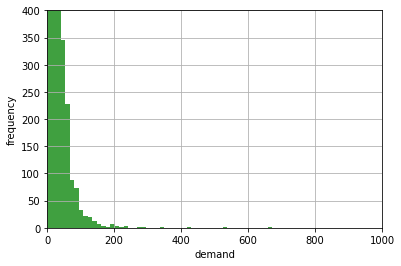

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

n, bins, patches = plt.hist(h, 50, facecolor='g', alpha=0.75)


plt.xlabel('demand')
plt.ylabel('frequency')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 1000)
plt.ylim(0, 400)
plt.grid(True)
plt.show()

##Fundamental preprocessing tasks
Some fundamental text preprocessing steps include lowercasing, punctuations removal, and removal of stopwords. 

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# print(stopwords.words('chinese'))
stopwords_list = stopwords.words('german')

def DescriptionProcessing(df):
  # remove non alphanumeric 
  df_LD['description_cleaned'] = df_LD.Description.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  df_LD.description_cleaned = df_LD.description_cleaned.str.lower()
  # split into list
  df_LD.description_cleaned = df_LD.description_cleaned.str.split(' ')
  # remove stopwords
  df_LD.description_cleaned = df_LD.description_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  return df

def DescriptionProcessing2(df):
  # remove non alphanumeric 
  test_LD['description_cleaned'] = test_LD.Description.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  test_LD.description_cleaned = test_LD.description_cleaned.str.lower()
  # split into list
  test_LD.description_cleaned = test_LD.description_cleaned.str.split(' ')
  # remove stopwords
  test_LD.description_cleaned = test_LD.description_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Lemmatization
For instance, the word ‘ran’ is lemmatized into ‘run’, ‘crying’ into ‘cry’, and ‘better’ into ‘good’. 

In [ ]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

clean_data = DescriptionProcessing(df_LD)
clean_data.description_cleaned = clean_data.description_cleaned.apply(' '.join)
clean_data['description_cleaned_lemmatized'] = clean_data.description_cleaned.apply(get_lemmatize)

clean_data_test = DescriptionProcessing(test_LD)
clean_data_test.description_cleaned = clean_data_test.description_cleaned.apply(' '.join)
clean_data_test['description_cleaned_lemmatized'] = clean_data_test.description_cleaned.apply(get_lemmatize)

In [ ]:
clean_data_test = DescriptionProcessing2(test_LD)
clean_data_test.description_cleaned = clean_data_test.description_cleaned.apply(' '.join)
clean_data_test['description_cleaned_lemmatized'] = clean_data_test.description_cleaned.apply(get_lemmatize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
print(clean_data['description_cleaned_lemmatized'])

0        suche neuen mietern fr geniale grosszgige wund...
1        ce logement se situe dans un btiment entiremen...
2        vereinbarung vermieten tolle wohnung folgende ...
3        vereinbarung vermieten attraktive sonnige 35zi...
4        cet appartement idalement situ proximit cole s...
                               ...                        
19995    per sofort vereinbarung vermieten grosse helle...
19996    dans un immeuble situ proximit immdiate lac et...
19997    dans immeuble scuris avec concierge secteur de...
19998    situ dans un immeuble la fois proche bord lac ...
19999    vermieten zentral grnen gelegenen liegenschaft...
Name: description_cleaned_lemmatized, Length: 19954, dtype: object


##Word Vectorization (Embedding) & ML Classifiers for Multi-Classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier()),
               ])


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=500)),
               ])

In [ ]:
x = clean_data['description_cleaned_lemmatized']
y = clean_data['Demand']
x2 = clean_data_test['description_cleaned_lemmatized']
# X_train, X_test, y_train, y_test = train_test_split(x, y, 
#                                                     test_size=0.2, random_state = 44)
X_train, y_train = x, y
X_test = x2

In [ ]:
clean_data['Demand']


0        25.0
1         2.0
2         0.0
3         4.0
4         3.0
         ... 
19995     2.0
19996     1.0
19997     2.0
19998     2.0
19999     3.0
Name: Demand, Length: 19954, dtype: float64

In [ ]:
# Logistic Regression
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print(accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

0.21874216988223502
[[702  95  35 ...   0   0   0]
 [371  93  37 ...   0   0   0]
 [250  82  42 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
              precision    recall  f1-score   support

         0.0       0.31      0.80      0.45       878
         1.0       0.15      0.18      0.16       529
         2.0       0.12      0.10      0.11       418
         3.0       0.05      0.04      0.05       303
         4.0       0.07      0.05      0.05       236
         5.0       0.08      0.03      0.04       198
         6.0       0.04      0.02      0.03       138
         7.0       0.04      0.02      0.02       132
         8.0       0.02      0.01      0.01       118
         9.0       0.00      0.00      0.00        99
        10.0       0.00      0.00      0.00        80
        11.0       0.00      0.00      0.00        61
        12.0       0.00      0.00      0.00        54
        13.0       0.00      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
